# Phishing Site Predictor

### Import Libraries

In [1]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix
import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # provide object-oriented API for embedding plots into applications
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from selenium import webdriver
import networkx as nx

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

### Loading Dataset

In [2]:
phish_data = pd.read_csv('phishing_site_urls.csv')

In [3]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [5]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [6]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

About the dataset: 
- dataset contains 549346 unique entries
- there are two columns:
    - URL column containing the website urls
    - Label column containing website url categorisation; good (not a phishing site) or bad (is a phishing site)
- there is no missing value in the dataset

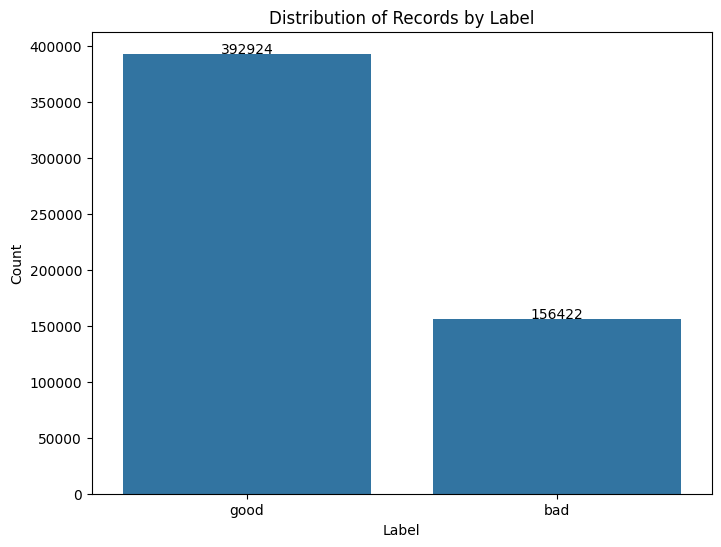

In [7]:
# Count occurence of records for each category in Label column
label_counts = phish_data['Label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values)

# Add count values on top of each bar
for i in range(len(label_counts)):
    barplot.text(x=i, y=label_counts.values[i] + 0.1, s=label_counts.values[i], ha='center')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Records by Label')

# Show the plot
plt.show()

### Data Preprocessing

RegexpTokenizer
- to extract the alphabet characters, disregarding the non-alphabetic characters from a link in the records in the dataset
- purpose is to extract more features from the data, to classify the web urls as good or bad sites

In [8]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [9]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [10]:
# tokenize the first URL
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [11]:
# Create a new column named 'text_tokenized' in the phish_data DataFrame
# This column will store the tokens of alphabets extracted from the URLs
phish_data['text_tokenized'] = (
    # Apply a function to each URL in the 'URL' column
    # The function tokenizes each URL using the declared tokenizer object
    phish_data['URL'].map(lambda t: tokenizer.tokenize(t))
)

In [12]:
phish_data.sample(10)

,URL,Label,text_tokenized
19468,ww2.history.observ.pay.objects.net.com-communi...,bad,"[ww, history, observ, pay, objects, net, com, ..."
286467,axiscontrols.co.uk/shop/KBRG_Range/48.aspx,good,"[axiscontrols, co, uk, shop, KBRG, Range, aspx]"
143900,arcadefirenews.com/,good,"[arcadefirenews, com]"
357594,imdb.com/language/yue,good,"[imdb, com, language, yue]"
301366,celebitchy.com/category/amy_fisher/,good,"[celebitchy, com, category, amy, fisher]"
189280,forum.canadianwoodworking.com/showthread.php?4...,good,"[forum, canadianwoodworking, com, showthread, ..."
398276,myspace.com/30542989,good,"[myspace, com]"
137468,hyperbarichealingcenter.com/includes/js/jscale...,bad,"[hyperbarichealingcenter, com, includes, js, j..."
343502,fundinguniverse.com/company-histories/Ellerbe-...,good,"[fundinguniverse, com, company, histories, Ell..."
88701,www.contextures.com/tiptech.html,good,"[www, contextures, com, tiptech, html]"


SnowballStemmer
- is a stemming algorithm used for reducing words to their root or base form 
- it is applied after tokenization to further preprocess the text data, normalizing it so that we can better process the text


In [13]:
stemmer = SnowballStemmer("english")

In [14]:
# Create a new column named 'text_stemmed' in the phish_data DataFrame
# Applying stemming to the tokenized words in the 'text_tokenized' column
phish_data['text_stemmed'] = (
    phish_data['text_tokenized'].map(lambda s: 
        # Iterate over each word in the tokenized list
        # and apply stemming using the SnowballStemmer object that we declared earlier
        [stemmer.stem(word) for word in s]
    )
)

In [15]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed
432377,slthermal.com/,good,"[slthermal, com]","[slthermal, com]"
482167,youthsymphonykc.org/,good,"[youthsymphonykc, org]","[youthsymphonykc, org]"
110586,prodentmed.com.br/site/dx123/home/,bad,"[prodentmed, com, br, site, dx, home]","[prodentm, com, br, site, dx, home]"
496498,nikulino.edusite.ru/u43pi00,bad,"[nikulino, edusite, ru, u, pi]","[nikulino, edusit, ru, u, pi]"
457339,usrowing.org/Pressbox/AthleteBios/RobertRasmus...,good,"[usrowing, org, Pressbox, AthleteBios, RobertR...","[usrow, org, pressbox, athletebio, robertrasmu..."
106083,studiomancini.legal/includes/js/calendar/lang/...,bad,"[studiomancini, legal, includes, js, calendar,...","[studiomancini, legal, includ, js, calendar, l..."
283439,arrestcentral.com/torrey-andre-daniels/,good,"[arrestcentral, com, torrey, andre, daniels]","[arrestcentr, com, torrey, andr, daniel]"
245269,tampalawblog.blogspot.com/,good,"[tampalawblog, blogspot, com]","[tampalawblog, blogspot, com]"
369116,koombahlapark.com.au/kprs_horsesales.html,good,"[koombahlapark, com, au, kprs, horsesales, html]","[koombahlapark, com, au, kprs, horsesal, html]"
507956,dokintanke.ru/gate.php,bad,"[dokintanke, ru, gate, php]","[dokintank, ru, gate, php]"


We will combine the stemmed words into single strings by joining them together with spaces. It helps to simplify the representation of text data, and making it more suitable for analysis, visualisation, and modeling purposes.

In [16]:
# Create a new column named 'text_sent' in the DataFrame 'phish_data'
phish_data['text_sent'] = (
    phish_data['text_stemmed'].map(lambda j: 
        # Join the stemmed words in each list into a single string separated by spaces
        ' '.join(j)
    )
)

In [17]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
119455,labiaplastypicture.com/mobile/signIn.php,bad,"[labiaplastypicture, com, mobile, signIn, php]","[labiaplastypictur, com, mobil, signin, php]",labiaplastypictur com mobil signin php
249943,trn.trains.com/en/Railroad%20News/News%20Wire/...,good,"[trn, trains, com, en, Railroad, News, News, W...","[trn, train, com, en, railroad, news, news, wi...",trn train com en railroad news news wire amtra...
328249,facebook.com/notes/twa/twa-flight-800-passenge...,good,"[facebook, com, notes, twa, twa, flight, passe...","[facebook, com, note, twa, twa, flight, passen...",facebook com note twa twa flight passeng list
220356,necmusic.edu/john-gibbons,good,"[necmusic, edu, john, gibbons]","[necmus, edu, john, gibbon]",necmus edu john gibbon
501248,mvpweekly.top/tvjsiink9lee+fidpfcrontm4kbl9k3o...,bad,"[mvpweekly, top, tvjsiink, lee, fidpfcrontm, k...","[mvpweek, top, tvjsiink, lee, fidpfcrontm, kbl...",mvpweek top tvjsiink lee fidpfcrontm kbl k obe...
381641,magicyellow.com/category/Farms/Zillah_WA.html,good,"[magicyellow, com, category, Farms, Zillah, WA...","[magicyellow, com, categori, farm, zillah, wa,...",magicyellow com categori farm zillah wa html
515532,91.239.25.127:6892,bad,[],[],
84569,oss.basjes.nl/SuckMT/,good,"[oss, basjes, nl, SuckMT]","[oss, basj, nl, suckmt]",oss basj nl suckmt
115589,cndoubleegret.com/admin/secure/cmd-login=36030...,bad,"[cndoubleegret, com, admin, secure, cmd, login...","[cndoubleegret, com, admin, secur, cmd, login,...",cndoubleegret com admin secur cmd login ed ba ...
8497,www.adventurebike.com.br/site/arquivos/user_97...,bad,"[www, adventurebike, com, br, site, arquivos, ...","[www, adventurebik, com, br, site, arquivo, us...",www adventurebik com br site arquivo user ed b...


### Visualisation

In [18]:
# Separate the data frame into bad and good urls
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [19]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [20]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


We will visualise the most common words that appear for bad and good sites respectively

In [31]:
from collections import Counter
def plot_wordcloud(text, title):
    # Generate word frequency counts
    word_freq = Counter(text.split())
    
    # Exclude default stopwords and additional stopwords
    stopwords = set(STOPWORDS).union({'com', 'http'})
    for stopword in stopwords:
        word_freq.pop(stopword, None)
    
    # Filter out the most common words (up to 400 words)
    common_words = dict(word_freq.most_common(400))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Convert text data for bad and good sites into single strings
bad_text = ' '.join(bad_sites['text_sent'])
good_text = ' '.join(good_sites['text_sent'])

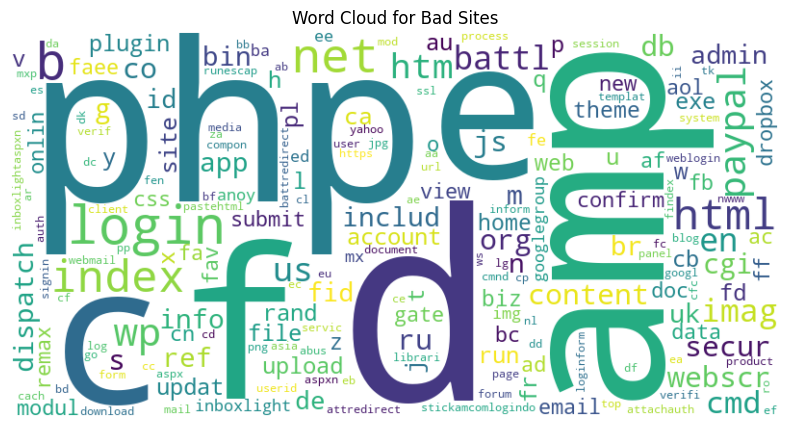

In [32]:
# Plot word cloud for bad sites
plot_wordcloud(bad_text, title='Word Cloud for Bad Sites')

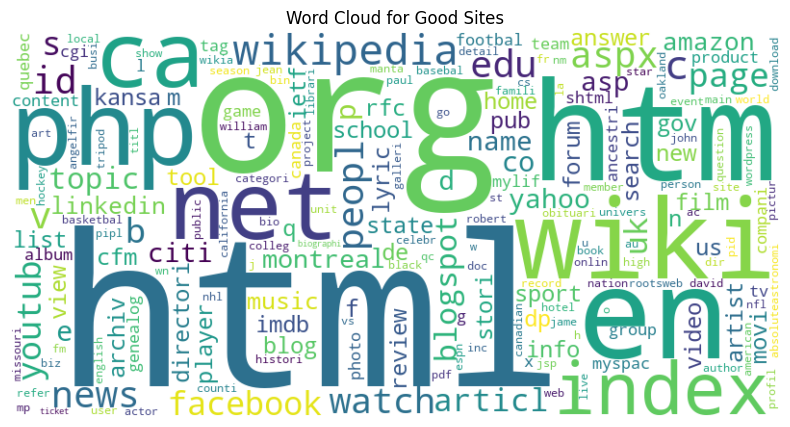

In [34]:
# Plot word cloud for good sites
plot_wordcloud(good_text, title='Word Cloud for Good Sites')